In [43]:
import numpy as np, math
from collections import deque, defaultdict as ddict

from matplotlib.figure import Figure

In [28]:
%matplotlib

Using matplotlib backend: <object object at 0x000001EA510E2FE0>


In [4]:
f = "C:\\Users\\kyler\\Documents\\DFCI\\Work\\sample\\shard.vcf"

In [90]:
xrms = np.loadtxt(f, usecols=(0), dtype='U')
pos = np.loadtxt(f, usecols=(1), dtype=np.int32)
buffer = 1000
max_span = 1e6

In [156]:
pos = np.arange(1, 5000000, 1500)
xrms = np.ones_like(pos)


In [157]:
L, U = np.clip(pos - buffer, 1, None), pos + buffer
stop = (L[1:] > U[:-1]) | (xrms[1:] != xrms[:-1])
I = np.nonzero(stop)[0]
iA, iB = np.concatenate([[0], I+1]), np.concatenate([I, [-1]])
A, B, X = L[iA], U[iB], xrms[iA]

Lens = B-A
Sum = Lens.sum()
nF = math.ceil(Sum/max_span)
lF = math.ceil(Sum/nF)


ValueError: operands could not be broadcast together with shapes (0,) (5,) 

In [155]:
np.array([(b-a).sum() for a,b in Frags]) - lF

array([0])

In [159]:
L, U, stop, I, A, B

(array([      1,     501,    2001, ..., 4995501, 4997001, 4998501]),
 array([   1001,    2501,    4001, ..., 4997501, 4999001, 5000501]),
 array([False, False, False, ..., False, False, False]),
 array([], dtype=int64),
 array([1]),
 array([5000501]))

In [161]:
Q, sTs, P, iQ

(array([5000500]),
 array([ 833417, 1666834, 2500251, 3333668, 4167085]),
 array([[ True],
        [ True],
        [ True],
        [ True],
        [ True]]),
 array([], dtype=int64))

In [142]:
M = np.array([[0,2,3],[4,5,6]])
np.concatenate([ [[7],[8]], M], axis=1)

array([[7, 0, 2, 3],
       [8, 4, 5, 6]])

In [92]:
Q[iQ]-sTs

array([1912, 2337, 1387,  158,  438])

In [114]:
[(b-a).sum() - lF for a,b in Frags]

[1912, 425, -950, -1229, 280, -441]

In [95]:
Lens[iQ]

array([2394, 4551, 2072, 2000, 2000])

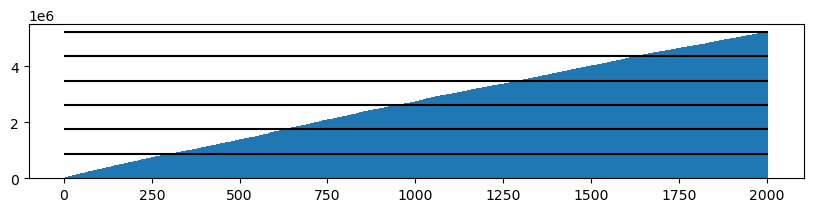

In [38]:
fig = Figure(figsize=(10,2))
ax = fig.subplots()

ax.bar(np.arange(len(Cum)), Cum, width=1)
ax.hlines(sTs, 0, 2005, colors=['k'])

fig

In [16]:
K = slice(10)
print(L[K])
print(U[K])
print(stop[K])
print(I[K])
print(A[K])
print(B[K])


[ 68270  68511  68897 929939 930131 940119 941335 941451 942136 942329]
[ 70270  70511  70897 931939 932131 942119 943335 943451 944136 944329]
[False False  True False  True False False False False False]
[ 2  4 19 26 51 62 74 76 82 83]
[  68270  929939  940119  951180  956080  969892  977812  998666 1012490
 1019217]
[  70897  932131  949245  954858  967689  977669  983112 1000842 1015509
 1021217]


# Final

In [ ]:
import math, sys, os
from collections import deque
import numpy as np

if len(sys.argv) < 4:
  print("Script requires 3 arguments: input vcf, buffer length, and maximum buffered span")

in_vcf = sys.argv[1]
buffer = int(sys.argv[2])
max_span = int(sys.argv[3])

xrms = np.loadtxt(in_vcf, usecols=(0), dtype='U')
pos = np.loadtxt(in_vcf, usecols=(1), dtype=np.int32)

# unfortunately numpy sorts before returning the unique elements,
#  so we have to unsort (i.e. re-sort the indices into order)
Xorder = list(xrms[sorted(np.unique(xrms, return_index=True)[1])])

L, U = np.clip(pos - buffer, 1, None), pos + buffer             # Lower, Upper buffers around each variant
I = np.nonzero((L[1:] > U[:-1]) | (xrms[1:] != xrms[:-1]))[0]   # where buffer boundaries _dont_ overlap
iA, iB = np.concatenate([[0], I+1]), np.concatenate([I, [-1]])  # lower, upper boundary buffer indices
X, A, B = xrms[iA], L[iA], U[iB]                                # bounding buffers
S = (B-A).sum()                                                 # total buffer span
T = math.ceil(S/math.ceil(S/max_span))                          # target fragment length

print(S, 'sized buffer to', T, 'length fragments')

# Yay borel sets
# deques pop from the end, so we have to load in backwards
borel = deque(list(zip(X, A, B))[::-1])
stop = deque()
s = 0

while len(borel) > 0:
    x, a, b = borel.pop() # deque supports O(1) resizing
    if b-a > (r := T-s): # split a buffer if it overflows a fragment
        m = a + r
        borel.append((x,m,b)) # another reason for the deque
        b = m
    s += b-a
    if s >= T:
        stop.append((x, b-1)) # accumulating fragment stopping points
        s = 0
stop.append((x, b))

print(f'Writing {len(stop)} fragments')
# And now the file work, which is always chunky
with open(in_vcf) as inp:
    header = ''
    for line in inp: # this is gonna bleed onto the first variant line
        if not line.startswith('#'): break
        header += line

    i = 0
    out = open(f'{in_vcf}.subshard_{i}.vcf', 'w')
    out.write(header)
    xf, pf = stop[i]
    xfi = Xorder.index(xf)
    out.write(line) # first variant is assumably in first fragment

    xrml = '-1'
    xrmi = '-1'

    for line in inp:
        xrm, pos, *_ = line.split('\t')

        if xrmi != xrm:
            xrml = xrm
            xrmi = Xorder.index(xrm)

        if (xrmi > xfi) or (xrmi == xfi and int(pos) > pf):
            out.close()

            i += 1
            out = open(f'{in_vcf}.subshard_{i}.vcf', 'w')
            out.write(header)
            xf, pf = stop[i]
            xfi = Xorder.index(xf)
        out.write(line)

    out.close()
print('Done!')